In [134]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss

import cooper
from cooper.optim import SGD
import style_utils

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Mixture of Gaussians

This example is inspired by Fig. 2 in Cotter et al. (2019)

In [135]:
# Generate dataset
n_per_class = 100
dim = 2
n_gaussians = 4
mus = [(0, 1), (-1, 0), (0, -1), (1, 0)]
mus = [torch.tensor(m) for m in mus]
var = 0.05

inputs, labels = [], []

for id in range(n_gaussians):
    # Generate input data by mu + x @ sqrt(cov)
    cov = np.sqrt(var) * torch.eye(dim)
    mu = mus[id]
    inputs.append(mu + torch.randn(n_per_class, dim) @ cov)

    # Labels
    labels.append(torch.tensor(n_per_class * [1. if id < 2 else 0.]))

INPUTS = torch.cat(inputs, dim=0)
LABELS = torch.cat(labels, dim=0)

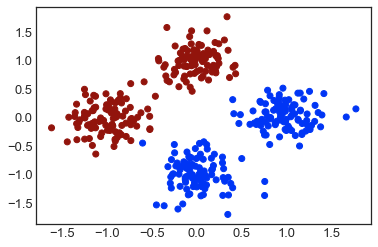

In [136]:
red, blue = style_utils.COLOR_DICT['red'], style_utils.COLOR_DICT['blue']
COLORS = [red if l == 1 else blue for l in LABELS.flatten()]

scatter = plt.scatter(*torch.transpose(INPUTS, 0, 1), color=COLORS)
plt.show()

### Constrained Minimization Problem

In [140]:
class MixtureSeparation(cooper.ConstrainedMinimizationProblem):
    def __init__(self, is_constrained, use_proxy=False, const_level=0.55):

        super().__init__(is_constrained=is_constrained)

        self.const_level = const_level
        self.use_proxy = use_proxy

        # Linear predictor
        self.linear = torch.nn.Linear(2, 1)

    def closure(self, inputs, targets):

        logits = self.linear(inputs)
        loss=bce_loss(logits.flatten(), targets)

        if not self.is_constrained:
            # Unconstrained problem of separating two classes
            state = cooper.CMPState(
                loss=loss,
            )

        if self.is_constrained:
            # Separating classes s.t. predicting at least 55% as class 0 (blue)

            # Hinge approximation of the rate
            probs = torch.sigmoid(logits)
            hinge = torch.mean(torch.max(torch.zeros_like(probs), 1 - probs))

            if not self.use_proxy:
                # Use a proxy for the constraint: a hinge relaxation
                state = cooper.CMPState(
                    loss=loss,
                    ineq_defect=self.const_level - hinge, # 55% - hinge approx <= 0
                )
            else:
                # Use non-proxy constraint defects to update the Lagrange multipliers

                # Proportion of elements in class 0 is the non-proxy defect
                classes = logits >= 0.
                prop_0 = torch.sum(classes == 0) / targets.numel()

                state = cooper.CMPState(
                    loss=loss,
                    ineq_defect=self.const_level - prop_0, # 55% - prop_0 <= 0
                    proxy_ineq_defect=self.const_level - hinge, # 55% - hinge approx <= 0
                )

        return state

### Training

In [154]:
constraint_level = 0.9
print_freq = 1000
models = []

for problem in ["unconstrained", "constrained", "proxy"]:

    print("\n" + problem)
    is_constrained = problem == "constrained" or problem == "proxy"
    use_proxy = problem == "proxy"

    cmp = MixtureSeparation(is_constrained, use_proxy, constraint_level)
    formulation = cooper.LagrangianFormulation(cmp)

    primal_optimizer = SGD(cmp.linear.parameters(), lr=1e-2)
    dual_optimizer = cooper.optim.partial(SGD, lr=1e-2) if is_constrained else None
    optimizer = cooper.ConstrainedOptimizer(
        formulation=formulation,
        primal_optimizer=primal_optimizer,
        dual_optimizer=dual_optimizer,
    )

    for i in range(5000):
        optimizer.zero_grad()
        if is_constrained:
            lagrangian = formulation.composite_objective(cmp.closure, INPUTS, LABELS)
            formulation.custom_backward(lagrangian)
            if i % print_freq == 0:
                print(
                    "\t Lag:", lagrangian.item(),
                    "\t Defect:", cmp.state.ineq_defect.item(),
                    "\t Multiplier:", formulation.state()[0].item()
                )
        else:
            loss = cmp.closure(INPUTS, LABELS).loss
            loss.backward()
            if i % print_freq == 0:
                print("Loss:", loss.item())

        optimizer.step()

    models.append(cmp.linear)


unconstrained
Loss: 0.9103453755378723
Loss: 0.2497933954000473
Loss: 0.14630509912967682
Loss: 0.10614567995071411
Loss: 0.08463595062494278

constrained
	 Lag: 0.8670411109924316 	 Defect: 0.29575860500335693 	 Multiplier: 0.0
	 Lag: 0.8483712673187256 	 Defect: 0.1510692834854126 	 Multiplier: 2.437405824661255
	 Lag: 0.8563318252563477 	 Defect: 0.061415672302246094 	 Multiplier: 3.401362657546997
	 Lag: 0.8623189330101013 	 Defect: 0.03631347417831421 	 Multiplier: 3.8695156574249268
	 Lag: 0.8662582039833069 	 Defect: 0.024874627590179443 	 Multiplier: 4.169888019561768

proxy
	 Lag: 0.8292129635810852 	 Defect: 0.037499964237213135 	 Multiplier: 0.0
	 Lag: 0.8495303988456726 	 Defect: 0.14499998092651367 	 Multiplier: 2.2967498302459717
	 Lag: 0.7710537910461426 	 Defect: -0.020000040531158447 	 Multiplier: 2.3514885902404785
	 Lag: 0.7590287923812866 	 Defect: 0.009999990463256836 	 Multiplier: 2.362210273742676
	 Lag: 0.7665797472000122 	 Defect: 0.009999990463256836 	 Multip

### Resulting boundary

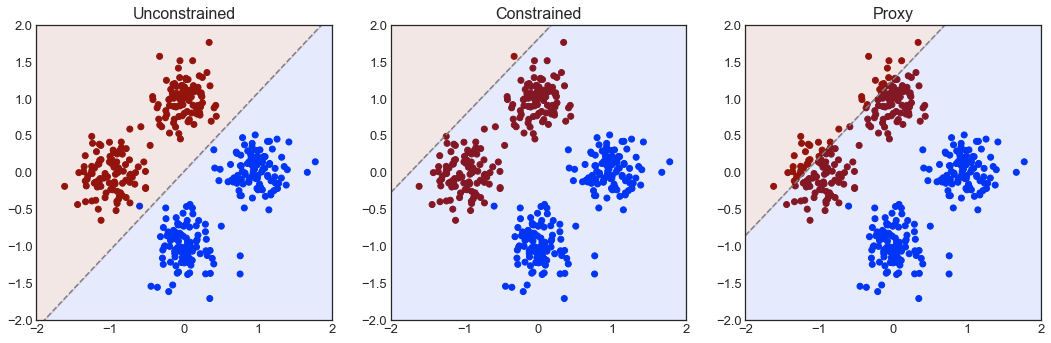

In [158]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Unconstrained", "Constrained", "Proxy"]

for idx, model in enumerate(models):
    weight = model.weight.data.flatten().numpy()
    bias = model.bias.data.numpy()

    # Reparametrize boundary as x2 = m * x1 + b
    m = -weight[0]/weight[1]
    b = -bias/weight[1]

    # Plot data and boundary
    x1 = np.linspace(-2, 2, 100)
    x2 = m*x1 + b

    ax = axs[idx]

    ax.scatter(*torch.transpose(INPUTS, 0, 1), color=COLORS)
    ax.plot(x1, x2, color="gray", linestyle="--")
    ax.fill_between(x1, -2, x2, color=blue, alpha=0.1)
    ax.fill_between(x1, x2, 2, color=red, alpha=0.1)

    ax.set_aspect("equal")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(titles[idx])

## References

- A. Cotter, H. Jiang, M. Gupta, S. Wang, T. Narayan, S. You,
and K. Sridharan. Optimization with Non-Differentiable
Constraints with Applications to Fairness, Recall, Churn,
and Other Goals. In JMLR, 2019.